# DiscreteDP

***Getting Started with Simple Examples***

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

This notebook demonstrates via simple examples how to use the `DiscreteDP` module.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import numpy as np
from scipy import sparse
import itertools
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

## A two-state example

Let us first consider the following two-state dynamic program,
taken from Puterman (2005), Section 3.1, pp.33-35;
see also Example 6.2.1, pp.155-156.

* There are two possible states $0$ and $1$.

* At state $0$, you may choose either "stay", say action $0$, or "move", action $1$.

* At state $1$, there is no way to move, so that you can only stay, i.e.,
  $0$ is the only available action.
  (You may alternatively distinguish between the action "staty" at state $0$
  and that at state $1$, and call the latter action $2$;
  but here we choose to refer to the both actions as action $0$.)

* At state $0$,
  if you choose action $0$ (stay),
  then you receive a reward $5$, and
  in the next period the state will remain at $0$ with probability $1/2$,
  but it moves to $1$ with probability $1/2$.

* If you choose action $1$ (move),
  then you receive a reward $10$, and
  the state in the next period will be $1$ with probability $1$.

* At state $1$, where the only action you can take is $0$ (stay),
  you receive a reward $-1$, and
  the state will remain at $1$ with probability $1$.

* You want to maximize the sum of discounted expected reward flows
  with discount factor $\beta \in [0, 1)$.

The optimization problem consists of:

* the state space: $S = \{0, 1\}$;

* the action space: $A = \{0, 1\}$;

* the set of feasible state-action pairs
  $\mathit{SA} = \{(0, 0), (0, 1), (1, 0)\} \subset S \times A$;

* the reward function $r\colon \mathit{SA} \to \mathbb{R}$, where
  $$
  r(0, 0) = 5,\ r(0, 1) = 10,\ r(1, 0) = -1;
  $$

* the transition probability function $q \colon \mathit{SA} \to \Delta(S)$, where
  $$
  (q(0 | 0, 0), q(1 | 0, 0)) = (1/2, 1/2),\ 
  (q(0 | 0, 1), q(1 | 0, 1)) = (0, 1),\ 
  (q(0 | 1, 0), q(1 | 1, 0)) = (0, 1);
  $$
  
* the discount factor $\beta \in [0, 1)$.

The Belmann equation for this problem is:
$$
\begin{aligned}
v(0) &= \max \left\{5 + \beta \left(\frac{1}{2} v(0) + \frac{1}{2} v(1)\right),
                    10 + \beta v(1)\right\}, \\
v(1) &= (-1) + \beta v(1).
\end{aligned}
$$

This problem is simple enough to solve by hand:
the optimal value function $v^*$ is given by
$$
\begin{aligned}
&v(0) =
\begin{cases}
\dfrac{5 - 5.5 \beta}{(1 - 0.5 \beta) (1 - \beta)} & \text{if $\beta > \frac{10}{11}$} \\
\dfrac{10 - 11 \beta}{1 - \beta} & \text{otherwise},
\end{cases}\\
&v(1) = -\frac{1}{1 - \beta},
\end{aligned}
$$
and the optimal policy function $\sigma^*$ is given by
$$
\begin{aligned}
&\sigma^*(0) =
\begin{cases}
0 & \text{if $\beta > \frac{10}{11}$} \\
1 & \text{otherwise},
\end{cases}\\
&\sigma^*(1) = 0.
\end{aligned}
$$

In [3]:
def v_star(beta):
    v = np.empty(2)
    v[1] = -1 / (1 - beta)
    if beta > 10/11:
        v[0] = (5 - 5.5*beta) / ((1 - 0.5*beta) * (1 - beta))
    else:
        v[0] = (10 - 11*beta) / (1 - beta)
    return v

We want to solve this problem numerically by using the `DiscreteDP` class.

We will set $\beta = 0.95$ ($> 10/11$), for which the anlaytical solution is:
$\sigma^* = (0, 0)$ and

In [4]:
v_star(beta=0.95)

array([ -8.57142857, -20.        ])

### Formulating the model

There are two ways to represent the data for instantiating a `DiscreteDP` object.
Let $n$, $m$, and $L$ denote the numbers of states, actions,
and feasbile state-action pairs, respectively;
in the above example, $n = 2$, $m = 2$, and $L = 3$.

1. `DiscreteDP(R, Q, beta)`
   
   with parameters:
   
   * $n \times m$ reward array `R`,
   * $n \times m \times n$ transition probability array `Q`, and
   * discount factor `beta`,
   
   where `R[s, a]` is the reward for action `a` when the state is `s` and
   `Q[s, a, s']` is the probability that the state in the next period is `s'`
   when the current state is `s` and the action chosen is `a`.

2. `DiscreteDP(R, Q, beta, s_indices, a_indices)`

   with parameters:
   
   * length $L$ reward vector `R`,
   * $L \times n$ transition probability array `Q`,
   * discount factor `beta`,
   * length $L$ array `s_indices`, and
   * length $L$ array `a_indices`,
   
   where the pairs `(s_indices[0], a_indices[0])`, ..., `(s_indices[L-1], a_indices[L-1])`
   enumerate feasible state-action pairs, and
   `R[i]` is the reward for action `a_indices[i]` when the state is `s_indices[i]` and
   `Q[i, s']` is the probability that the state in the next period is `s'`
   when the current state is `s_indices[i]` and the action chosen is `a_indices[0]`.

### Creating a `DiscreteDP` instance

Let us illustrate the two formulations by the simple example at the outset.

#### Product formulation

This formulation is straightforward
when the number of feasible actions is constant across states
so that the set of feasible state-action pairs is naturally represetend
by the product $S \times A$,
while any problem can actually be represented in this way
by defining the reward `R[s, a]` to be $-\infty$ when action `a` is infeasible under state `s`.

To apply this approach to the current example,
we consider the effectively equivalent problem
in which at both states $0$ and $1$,
both actions $0$ (stay) and $1$ (move) are available,
but action $1$ yields a reward $-\infty$ at state $1$.

The reward array `R` is an $n \times m$ 2-dimensional array:

In [5]:
R = [[5, 10],
     [-1, -float('inf')]]

The transition probability array `Q` is an $n \times m \times n$ 3-dimenstional array:

In [6]:
Q = [[(0.5, 0.5), (0, 1)],
     [(0, 1), (0.5, 0.5)]] # Probabilities in Q[1, 1] are arbitrary

Note that the transition probabilities for action $(s, a) = (1, 1)$ are arbitrary,
since $a = 1$ is infeasible at $s = 1$ in the original problem.

Let us set the discount factor $\beta$ to be $0.95$:

In [7]:
beta = 0.95

We are ready to create a `DiscreteDP` instance:

In [8]:
ddp = DiscreteDP(R, Q, beta)

#### State-action pairs formulation

When the number of feasible actions varies across states,
it can be inefficient in terms of memory usage
to extend the domain by treating infeasible actions
to be "feasible but yielding reward $-\infty$".
This formulation takes the set of feasible state-action pairs as is,
defining `R` to be a 1-dimensional array of length `L`
and `Q` to be a 2-dimensional array of shape `(L, n)`,
where `L` is the number of feasible state-action pairs.

First, we have to list all the feasible state-action pairs.
For our example, they are: $(s, a) = (0, 0), (0, 1), (1, 0)$.

We have arrays `s_indices` and ` a_indices` of length $3$
contain the indices of states and actions, respectively.

In [9]:
s_indices = [0, 0, 1]  # State indices
a_indices = [0, 1, 0]  # Action indices

The reward vector `R` is a length $L$ 1-dimensional array:

In [10]:
# Rewards for (s, a) = (0, 0), (0, 1), (1, 0), respectively
R = [5, 10, -1]

The transition probability array `Q` is an $L \times n$ 2-dimensional array:

In [11]:
# Probability vectors for (s, a) = (0, 0), (0, 1), (1, 0), respectively
Q = [(0.5, 0.5), (0, 1), (0, 1)]

For the discount factor, set $\beta = 0.95$ as before:

In [12]:
beta = 0.95

Now create a `DiscreteDP` instance:

In [13]:
ddp_sa = DiscreteDP(R, Q, beta, s_indices, a_indices)

##### Notes

Importantly, this formulation allows us to represent the transition probability array `Q`
as a [`scipy.sparse`](http://docs.scipy.org/doc/scipy/reference/sparse.html) matrix
(of any format),
which is useful for large and sparse problems.

For example, let us convert the above ndarray `Q` to the Coordinate (coo) format:

In [14]:
import scipy.sparse
Q = scipy.sparse.coo_matrix(Q)

Pass it to `DiscreteDP` with the other parameters:

In [15]:
ddp_sparse = DiscreteDP(R, Q, beta, s_indices, a_indices)

Internally, the matrix `Q` is converted to the Compressed Sparse Row (csr) format:

In [16]:
ddp_sparse.Q

<3x2 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [17]:
ddp_sparse.Q.toarray()

array([[ 0.5,  0.5],
       [ 0. ,  1. ],
       [ 0. ,  1. ]])

### Solving the model

Now let us solve our model.
Currently, `DiscreteDP` supports the following solution algorithms:

* policy iteration;
* value iteration;
* modified policy iteration.

(The methods are the same across the formulations.)

#### Policy iteration

We solve the model first by policy iteration,
which gives the exact solution:

In [18]:
v_init = [0, 0]  # Initial value function, optional(default=max_a r(s, a))
res = ddp.solve(method='policy_iteration', v_init=v_init)

`res` contains the information about the solution result:

In [19]:
res

       mc: Markov chain with transition matrix 
P = 
[[ 0.5  0.5]
 [ 0.   1. ]]
        v: array([ -8.57142857, -20.        ])
 max_iter: 250
    sigma: array([0, 0])
 num_iter: 2
   method: 'policy iteration'

The optimal policy function:

In [20]:
res.sigma

array([0, 0])

The optimal value function:

In [21]:
res.v

array([ -8.57142857, -20.        ])

This coincides with the analytical solution:

In [22]:
v_star(beta)

array([ -8.57142857, -20.        ])

In [23]:
np.allclose(res.v, v_star(beta))

True

The number of iterations:

In [24]:
res.num_iter

2

Verify that the value of the policy `[0, 0]` is actually equal to the optimal value `v`:

In [25]:
ddp.evaluate_policy(res.sigma)

array([ -8.57142857, -20.        ])

In [26]:
ddp.evaluate_policy(res.sigma) == res.v

array([ True,  True], dtype=bool)

`res.mc` is the controlled Markov chain given by the optimal policy `[0, 0]`:

In [27]:
res.mc

Markov chain with transition matrix 
P = 
[[ 0.5  0.5]
 [ 0.   1. ]]

#### Value iteration

Next, solve the model by value iteration,
which returns an $\varepsilon$-optimal solution for a specified value of $\varepsilon$:

In [28]:
epsilon = 1e-2  # Convergece tolerance, optional(default=1e-3)
v_init = [0, 0]  # Initial value function, optional(default=max_a r(s, a))
res_vi = ddp.solve(method='value_iteration', v_init=v_init,
                   epsilon=epsilon)

In [29]:
res_vi

       mc: Markov chain with transition matrix 
P = 
[[ 0.5  0.5]
 [ 0.   1. ]]
        v: array([ -8.5665053 , -19.99507673])
  epsilon: 0.01
 max_iter: 250
    sigma: array([0, 0])
 num_iter: 162
   method: 'value iteration'

The computed policy function `res1.sigma` is an $\varepsilon$-optimal policy,
and the value function `res1.v` is an $\varepsilon/2$-approximation
of the true optimal value function.

In [30]:
np.abs(v_star(beta) - res_vi.v).max()

0.0049232745189442539

#### Modified policy iteration

Finally, solve the model by modified policy iteration:

In [31]:
epsilon = 1e-2  # Convergece tolerance, optional(defaul=1e-3)
v_init = [0, 0]  # Initial value function, optional(default=max_a r(s, a))
res_mpi = ddp.solve(method='modified_policy_iteration', v_init=v_init,
                    epsilon=epsilon)

In [32]:
res_mpi

       mc: Markov chain with transition matrix 
P = 
[[ 0.5  0.5]
 [ 0.   1. ]]
  epsilon: 0.01
        k: 20
 max_iter: 250
   method: 'modified policy iteration'
        v: array([ -8.57142826, -19.99999965])
    sigma: array([0, 0])
 num_iter: 3

Modified policy function also returns an $\varepsilon$-optimal policy function
and an $\varepsilon/2$-approximate value function:

In [33]:
np.abs(v_star(beta) - res_mpi.v).max()

3.4711384344632279e-07

## A consumption-saving model

As a bigger, but still simple, example,
let us consider the following consumption-saving model
as described in Stachurski (2009), Section 5.1:
* the production is drawn from the uniform distribution on $\{0, \ldots, B\}$;
* the storage is limited by $M$;
* the stock is equal to the storage from the last period plus the production in the current period;
* some part of the stock is consumed and the other is stored (up to $M$);
* the flow utility is given by $u(c) = c^{\alpha}$, where $c$ is the consumption; and
* the discount factor is $\beta \in [0, 1)$.

We take the stock as the state variable $s$ and the storage as the action (control) variable $a$
(of course one may take the consumption as the action).
Then,
* the state space is $S = \{0, \ldots, M + B\}$: the number of states is $n = M + B + 1$;
* the action space is $A = \{0, \ldots, M\}$: the number of actions is $m = M + 1$; and
* the set of feasible actions when the current state is $s$ is
  $A(s) = \{0, \ldots, \min\{s, M\}\}$.

The Bellman equation is
$$
v(s) = \max_{a \in A(s)} u(s - a) + \beta \sum_{s' = a}^{a+B} \frac{1}{B+1} v(s')
\quad (s \in S).
$$

We use the parameter values (as in Listing 5.1 on page 104):

In [34]:
B, M = 10, 5
n, m = M + B + 1, M + 1
alpha = 0.5
beta = 0.9

Utility funciton:

In [35]:
def u(c):
    return c**alpha

### Creating a `DiscreteDP` instance

We demonstrate the two ways to pass the data to the `DiscreteDP` class.

#### Product formulation

This approach represents the data by
* the $n \times m$ reward array `R`,
  where $R[s, a] = u(s - a)$ if $a \leq s$ and $-\infty$ otherwise; and
* the $n \times m \times n$ transition probability array `Q`,
  where for any $s \in S$, $Q[s, a, s'] = 1/(B + 1)$ if $a \leq s' \leq a + B$,
  and $0$ otherwise.

The feasiblity constraint is embedded into `R`
by setting $R[s, a] = -\infty$ for $a \notin A(s)$.
Probability distributions for $(s, a)$ with $a \notin A(s)$ are arbitrary.

Reward array:

In [36]:
R = np.empty((n, m))
for s, a in itertools.product(range(n), range(m)):
    R[s, a] = u(s - a) if a <= s else -np.inf

In [37]:
print(R)

[[ 0.                -inf        -inf        -inf        -inf        -inf]
 [ 1.          0.                -inf        -inf        -inf        -inf]
 [ 1.41421356  1.          0.                -inf        -inf        -inf]
 [ 1.73205081  1.41421356  1.          0.                -inf        -inf]
 [ 2.          1.73205081  1.41421356  1.          0.                -inf]
 [ 2.23606798  2.          1.73205081  1.41421356  1.          0.        ]
 [ 2.44948974  2.23606798  2.          1.73205081  1.41421356  1.        ]
 [ 2.64575131  2.44948974  2.23606798  2.          1.73205081  1.41421356]
 [ 2.82842712  2.64575131  2.44948974  2.23606798  2.          1.73205081]
 [ 3.          2.82842712  2.64575131  2.44948974  2.23606798  2.        ]
 [ 3.16227766  3.          2.82842712  2.64575131  2.44948974  2.23606798]
 [ 3.31662479  3.16227766  3.          2.82842712  2.64575131  2.44948974]
 [ 3.46410162  3.31662479  3.16227766  3.          2.82842712  2.64575131]
 [ 3.60555128  3.46410162

In [38]:
R.shape

(16, 6)

Transition probability array:

In [39]:
Q = np.zeros((n, m, n))
for a in range(m):
    Q[:, a, a:a+B+1] = 1/(B+1)

In [40]:
Q[0, 0]

array([ 0.09090909,  0.09090909,  0.09090909,  0.09090909,  0.09090909,
        0.09090909,  0.09090909,  0.09090909,  0.09090909,  0.09090909,
        0.09090909,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [41]:
Q.shape

(16, 6, 16)

Construct a `DiscreteDP` instance:

In [42]:
ddp = DiscreteDP(R, Q, beta)

#### State-action pairs formulation

This approach represents the data by
* the length $L$ reward vector `R`,
  where, for $i = (s, a)$, $R[i] = u(s - a)$; and
* the $L \times n$ transition probability array `Q`,
  where, for $i = (s, a)$, $Q[i, s'] = 1/(B + 1)$ if $a \leq s' \leq a + B$,
  and $0$ otherwise.

First, we need to construct `s_indices` and `a_indices`.

In [43]:
S = np.arange(n).reshape((n, 1))
A = np.arange(m).reshape((1, m))
C = S - A  # Consumption matrix, negative comsumption included

The indices of feasible states and actions are those for which consumption is nonnegative:

In [44]:
s_indices, a_indices = np.where(C >= 0)

In [45]:
print(s_indices)

[ 0  1  1  2  2  2  3  3  3  3  4  4  4  4  4  5  5  5  5  5  5  6  6  6  6
  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10
 10 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14
 15 15 15 15 15 15]


In [46]:
print(a_indices)

[0 0 1 0 1 2 0 1 2 3 0 1 2 3 4 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2 3 4 5]


Reward array

In [47]:
R = u(C[s_indices, a_indices])

In [48]:
print(R)

[ 0.          1.          0.          1.41421356  1.          0.
  1.73205081  1.41421356  1.          0.          2.          1.73205081
  1.41421356  1.          0.          2.23606798  2.          1.73205081
  1.41421356  1.          0.          2.44948974  2.23606798  2.
  1.73205081  1.41421356  1.          2.64575131  2.44948974  2.23606798
  2.          1.73205081  1.41421356  2.82842712  2.64575131  2.44948974
  2.23606798  2.          1.73205081  3.          2.82842712  2.64575131
  2.44948974  2.23606798  2.          3.16227766  3.          2.82842712
  2.64575131  2.44948974  2.23606798  3.31662479  3.16227766  3.
  2.82842712  2.64575131  2.44948974  3.46410162  3.31662479  3.16227766
  3.          2.82842712  2.64575131  3.60555128  3.46410162  3.31662479
  3.16227766  3.          2.82842712  3.74165739  3.60555128  3.46410162
  3.31662479  3.16227766  3.          3.87298335  3.74165739  3.60555128
  3.46410162  3.31662479  3.16227766]


In [49]:
R.shape

(81,)

Transition probability array:

In [50]:
L = len(R)

# To use dense martrix format:
Q = np.zeros((L, n))

# To use sparse matrix format:
# Q = sparse.lil_matrix((L, n))

for i, a in enumerate(a_indices):
    Q[i, a:a+(B+1)] = 1/(B+1)

In [51]:
Q[0]

array([ 0.09090909,  0.09090909,  0.09090909,  0.09090909,  0.09090909,
        0.09090909,  0.09090909,  0.09090909,  0.09090909,  0.09090909,
        0.09090909,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [52]:
Q.shape

(81, 16)

Construct a `DiscreteDP`:

In [53]:
ddp_sa = DiscreteDP(R, Q, beta, s_indices, a_indices)

### Solving the model

#### Policy iteration

In [54]:
res = ddp.solve(method='policy_iteration')
v, sigma, mc, num_iter = res.v, res.sigma, res.mc, res.num_iter

Number of iterations:

In [55]:
num_iter

3

Optimal policy:

In [56]:
res.sigma

array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 5, 5])

Optimal value function:

In [57]:
res.v

array([ 19.01740222,  20.01740222,  20.43161578,  20.74945302,
        21.04078099,  21.30873018,  21.54479816,  21.76928181,
        21.98270358,  22.18824323,  22.3845048 ,  22.57807736,
        22.76109127,  22.94376708,  23.11533996,  23.27761762])

Check that the controlled Markov chain is irreducible and aperiodic:

In [58]:
mc.is_irreducible and mc.is_aperiodic

True

The (unique) stationary distribution:

In [59]:
stationary_dist = mc.stationary_distributions[0]
print(stationary_dist)

[ 0.01732187  0.04121063  0.05773956  0.07426848  0.08095823  0.09090909
  0.09090909  0.09090909  0.09090909  0.09090909  0.09090909  0.07358722
  0.04969846  0.03316953  0.01664061  0.00995086]


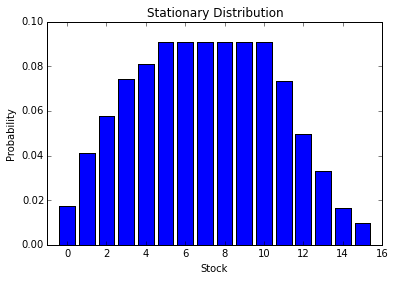

In [60]:
fig, ax = plt.subplots()
ax.bar(range(n), stationary_dist, align='center')
ax.set_xlim(-1, n)
ax.set_xlabel('Stock')
ax.set_ylabel('Probability')
ax.set_title('Stationary Distribution')
plt.show()

Expected average value:

In [61]:
stationary_dist.dot((1 - ddp.beta) * v)

2.1673779353215248

#### Value iteration

In [62]:
res_vi = ddp.solve(method='value_iteration')

Number of iterations:

In [63]:
res_vi.num_iter

101

Chech that the correct policy is returned:

In [64]:
np.array_equal(res_vi.sigma, sigma)

True

Deviation of the output value from that of policy iteration:

In [65]:
np.abs(res_vi.v - v).max()

0.00045734496477578546

#### Modified policy iteration

In [66]:
res_mpi = ddp.solve(method='modified_policy_iteration')

Number of iterations:

In [67]:
res_mpi.num_iter

5

Chech that the correct policy is returned:

In [68]:
np.array_equal(res_mpi.sigma, sigma)

True

Deviation of the output value from that of policy iteration:

In [69]:
np.abs(res_mpi.v - v).max()

1.7408297026122455e-13

### Simulating the Markov Chain

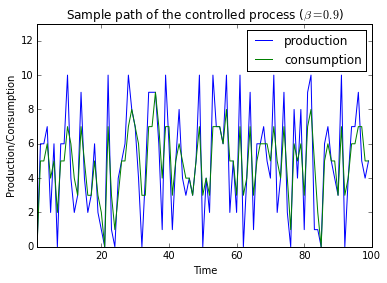

In [70]:
ts_length = 100
path_stock = mc.simulate(ts_length=ts_length, init=0)

path_storage = sigma[path_stock]
path_production = np.zeros(ts_length)
path_production[1:] = path_stock[1:] - path_storage[:-1]
path_consumption = path_stock - path_storage

fig, ax = plt.subplots()
ax.plot(path_production, label='production')
ax.plot(path_consumption, label='consumption')
ax.set_xlim(1, ts_length)
ax.set_ylim(0, B+3)
ax.set_title(r'Sample path of the controlled process ($\beta = {0}$)'.format(ddp.beta))
ax.set_xlabel('Time')
ax.set_ylabel('Production/Consumption')
plt.legend()
plt.show()

### Lower discount factor

Let us consider a lower discount factor:

In [71]:
ddp.beta = 0.7
res = ddp.solve(method='policy_iteration')
v, sigma, mc, num_iter = res.v, res.sigma, res.mc, res.num_iter

In [72]:
num_iter

2

In [73]:
sigma

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3])

Expected average value:

In [74]:
mc.stationary_distributions[0].dot((1 - ddp.beta) * v)

2.1021097576017902

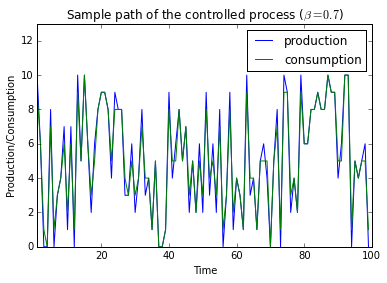

In [75]:
ts_length = 100
path_stock = mc.simulate(ts_length=ts_length, init=0)

path_storage = sigma[path_stock]
path_production = np.zeros(ts_length)
path_production[1:] = path_stock[1:] - path_storage[:-1]
path_consumption = path_stock - path_storage

fig, ax = plt.subplots()
ax.plot(path_production, label='production')
ax.plot(path_consumption, label='consumption')
ax.set_xlim(1, ts_length)
ax.set_ylim(0, B+3)
ax.set_title(r'Sample path of the controlled process ($\beta = {0}$)'.format(ddp.beta))
ax.set_xlabel('Time')
ax.set_ylabel('Production/Consumption')
plt.legend()
plt.show()

One can observe that consumption is slightly less "smooth".

### Notes

In the state-action pairs formulation,
`s_indices` and `a_indices` may be ordered arbitrarily;
they will internally be sorted in a lexicographic order.

In [76]:
print(s_indices[:16])
print(a_indices[:16])

[0 1 1 2 2 2 3 3 3 3 4 4 4 4 4 5]
[0 0 1 0 1 2 0 1 2 3 0 1 2 3 4 0]


In [77]:
# Shuffle s_indices and a_indices randomly
x = np.arange(L)
np.random.shuffle(x)
s_indices, a_indices = s_indices[x], a_indices[x]

In [78]:
print(s_indices[:16])
print(a_indices[:16])

[11  7 15 14  2  6  6 12 12 15  9 14  8 11  7 10]
[5 5 5 0 1 4 0 1 4 3 5 3 5 4 4 1]


In [79]:
# Construct the reward vector and the transition probability array
R = u(C[s_indices, a_indices])
Q = np.zeros((L, n))
for i, a in enumerate(a_indices):
    Q[i, a:a+(B+1)] = 1/(B+1)

In [80]:
print(R)

[ 2.44948974  1.41421356  3.16227766  3.74165739  1.          1.41421356
  2.44948974  3.31662479  2.82842712  3.46410162  2.          3.31662479
  1.73205081  2.64575131  1.73205081  3.          3.60555128  2.23606798
  2.82842712  2.64575131  3.16227766  3.87298335  3.31662479  3.46410162
  0.          1.41421356  1.          2.          2.23606798  3.
  1.73205081  3.          1.73205081  1.          2.          3.16227766
  2.44948974  2.64575131  3.31662479  3.          0.          2.64575131
  0.          2.23606798  3.46410162  2.          3.16227766  3.60555128
  1.          3.16227766  3.          3.16227766  1.          2.23606798
  1.          2.82842712  2.82842712  2.64575131  2.44948974  0.
  2.44948974  3.46410162  0.          1.41421356  2.82842712  2.23606798
  2.          0.          1.73205081  2.          3.31662479  2.82842712
  1.41421356  2.44948974  2.23606798  3.60555128  1.41421356  3.
  3.74165739  2.64575131  1.73205081]


In [81]:
print(Q[0])

[ 0.          0.          0.          0.          0.          0.09090909
  0.09090909  0.09090909  0.09090909  0.09090909  0.09090909  0.09090909
  0.09090909  0.09090909  0.09090909  0.09090909]


In [82]:
ddp_sa = DiscreteDP(R, Q, beta, s_indices, a_indices)

In [83]:
print(ddp_sa.s_indices)
print(ddp_sa.a_indices)

[ 0  1  1  2  2  2  3  3  3  3  4  4  4  4  4  5  5  5  5  5  5  6  6  6  6
  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10
 10 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14
 15 15 15 15 15 15]
[0 0 1 0 1 2 0 1 2 3 0 1 2 3 4 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2 3 4 5]


In [84]:
print(ddp_sa.R)

[ 0.          1.          0.          1.41421356  1.          0.
  1.73205081  1.41421356  1.          0.          2.          1.73205081
  1.41421356  1.          0.          2.23606798  2.          1.73205081
  1.41421356  1.          0.          2.44948974  2.23606798  2.
  1.73205081  1.41421356  1.          2.64575131  2.44948974  2.23606798
  2.          1.73205081  1.41421356  2.82842712  2.64575131  2.44948974
  2.23606798  2.          1.73205081  3.          2.82842712  2.64575131
  2.44948974  2.23606798  2.          3.16227766  3.          2.82842712
  2.64575131  2.44948974  2.23606798  3.31662479  3.16227766  3.
  2.82842712  2.64575131  2.44948974  3.46410162  3.31662479  3.16227766
  3.          2.82842712  2.64575131  3.60555128  3.46410162  3.31662479
  3.16227766  3.          2.82842712  3.74165739  3.60555128  3.46410162
  3.31662479  3.16227766  3.          3.87298335  3.74165739  3.60555128
  3.46410162  3.31662479  3.16227766]


In [85]:
print(ddp_sa.Q[0])

[ 0.09090909  0.09090909  0.09090909  0.09090909  0.09090909  0.09090909
  0.09090909  0.09090909  0.09090909  0.09090909  0.09090909  0.          0.
  0.          0.          0.        ]


## References

* M.L. Puterman,
  [*Markov Decision Processes: Discrete Stochastic Dynamic Programming*](http://onlinelibrary.wiley.com/book/10.1002/9780470316887),
  Wiley-Interscience, 2005.
  
* J. Stachursk,
  [*Economic Dynamics: Theory and Computation*](http://johnstachurski.net/edtc.html)
  MIT Press, 2009.